In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/My\ Drive/data1/dataset1.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset1/val/Negative/15194.jpg  
  inflating: dataset1/val/Negative/15201.jpg  
  inflating: dataset1/val/Negative/15203.jpg  
  inflating: dataset1/val/Negative/15206.jpg  
  inflating: dataset1/val/Negative/15211.jpg  
  inflating: dataset1/val/Negative/15222.jpg  
  inflating: dataset1/val/Negative/15225.jpg  
  inflating: dataset1/val/Negative/15232.jpg  
  inflating: dataset1/val/Negative/15241.jpg  
  inflating: dataset1/val/Negative/15246.jpg  
  inflating: dataset1/val/Negative/15247.jpg  
  inflating: dataset1/val/Negative/15251.jpg  
  inflating: dataset1/val/Negative/15265.jpg  
  inflating: dataset1/val/Negative/15268.jpg  
  inflating: dataset1/val/Negative/15278.jpg  
  inflating: dataset1/val/Negative/15280.jpg  
  inflating: dataset1/val/Negative/15289.jpg  
  inflating: dataset1/val/Negative/15293.jpg  
  inflating: dataset1/val/Negative/15300.jpg  
  inflating: dataset1/val/Negative/15302.jpg  
  inflati

# Data Augmentation

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [4]:
def build_dataset(dataset_path,training_path_prefix,test_path_prefix,target_size,batch_size):   
    train_datagen = ImageDataGenerator(
        rescale=1./255, 
        zoom_range=0.3, 
        rotation_range=90,
        width_shift_range=0.05, 
        height_shift_range=0.05, 
        shear_range=0.2, 
        horizontal_flip=True, 
        vertical_flip=True, 
        channel_shift_range=50.0,
        fill_mode='nearest'
    )
    test_datagen = ImageDataGenerator(rescale=1./255)

    training_set_generator = train_datagen.flow_from_directory(
            dataset_path+training_path_prefix,
            (INPUT_IMG_DIM,INPUT_IMG_DIM),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=True,
            seed=42
        )
    test_set_generator = test_datagen.flow_from_directory(
        dataset_path+test_path_prefix,
        (INPUT_IMG_DIM,INPUT_IMG_DIM),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=42
    )    
    return training_set_generator, test_set_generator

In [14]:
INPUT_IMG_DIM = 120
BATCH_SIZE = 32
DATASET_PATH="/content/dataset1"
TRAINING_PATH_PREFIX="/train"
TEST_PATH_PREFIX="/val"

In [6]:
training_set_generator, test_set_generator = build_dataset(
    DATASET_PATH,
    TRAINING_PATH_PREFIX,
    TEST_PATH_PREFIX,
    (INPUT_IMG_DIM,INPUT_IMG_DIM),
    BATCH_SIZE
)

Found 31906 images belonging to 2 classes.
Found 8094 images belonging to 2 classes.


# VGG-16

In [17]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
import tensorflow.keras




In [ ]:
# Base VGG
vgg = vgg16.VGG16(
    include_top=False, 
    weights='imagenet', 
    input_shape=(INPUT_IMG_DIM, INPUT_IMG_DIM, 3)
)

# Flatten output layer
output = vgg.layers[-1].output
output = tensorflow.keras.layers.Flatten()(output)

vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg_model.layers:
    layer.trainable = False

vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 30, 128)       0     

# layer

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer 
from tensorflow.keras.models import Sequential 
from tensorflow.keras import optimizers 

model = Sequential() 
model.add(vgg_model) 
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.3)) 
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.3)) 
model.add(Dense(2, activation='softmax')) 

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.RMSprop(lr=2e-5), 
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Training

In [ ]:
def train_vgg( model,
               target_size,
               dataset_path,
               training_path_prefix,
               test_path_prefix,                        
               history_file_path,
               history_filename,
               checkpoint_path,
               checkpoint_prefix,
               number_of_epochs,
               tensorboard_log_path
            ):
   
    step_size_train=training_set_generator.n//training_set_generator.batch_size
    step_size_validation=test_set_generator.n//test_set_generator.batch_size

    check_pointer = ModelCheckpoint(
            checkpoint_path + '%s_weights.{epoch:02d}-{val_loss:.2f}.hdf5' % checkpoint_prefix, 
            monitor='val_loss', 
            mode='auto', 
            save_best_only=True
    )
    
    tensorboard_logger = TensorBoard( 
        log_dir=tensorboard_log_path, histogram_freq=0,  
          write_graph=True, write_images=True
    )
    tensorboard_logger.set_model(model)

    csv_logger = CSVLogger(filename=history_file_path+history_filename)
    history = model.fit_generator(
            training_set_generator,
            steps_per_epoch=step_size_train,
            epochs=number_of_epochs,
            validation_data=test_set_generator,
            validation_steps=step_size_validation,
            callbacks=[check_pointer, csv_logger,tensorboard_logger],
            verbose=True        
    )

In [ ]:
MODEL_NAME="vgg"

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import ELU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard

from IPython.display import SVG
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [ ]:

train_vgg(  model,
            target_size=(120,120),
            dataset_path="/content/dataset1",
            training_path_prefix="train",
            test_path_prefix="val",
            history_file_path="/content"+"/training_logs/",
            history_filename=MODEL_NAME+".csv",
            checkpoint_path="/content"+"/model-checkpoints/",
            checkpoint_prefix=MODEL_NAME,
            number_of_epochs=30, 
            tensorboard_log_path="/content"+"/tensorboard_logs/",
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
997/997 [==============================] - 220s 216ms/step - loss: 0.1725 - accuracy: 0.9314 - val_loss: 0.0164 - val_accuracy: 0.9953
Epoch 2/30
997/997 [==============================] - 212s 212ms/step - loss: 0.0242 - accuracy: 0.9924 - val_loss: 0.0142 - val_accuracy: 0.9957
Epoch 3/30
997/997 [==============================] - 211s 211ms/step - loss: 0.0285 - accuracy: 0.9936 - val_loss: 0.0162 - val_accuracy: 0.9950
Epoch 4/30
997/997 [==============================] - 209s 209ms/step - loss: 0.0219 - accuracy: 0.9943 - val_loss: 0.0135 - val_accuracy: 0.9958
Epoch 5/30
997/997 [==============================] - 213s 213ms/step - loss: 0.0214 - accuracy: 0.9943 - val_loss: 0.0121 - val_accuracy: 0.9964
Epoch 6/30
997/997 [==============================] - 212s 213ms/step - loss: 0.0239 - accuracy: 0.9942 - val_loss: 0.0120 - val_accuracy: 0.9965
Epoch 7/30
997/997 [==============================] - 213s 213ms/step - loss: 0.0229 - accuracy: 0.9947 - val_loss: 0.0116 -

In [27]:
#we are getting val_loss: 0.0107 and val_accuracy: 0.9975

# Visualization


In [ ]:
import matplotlib.pyplot as plt
import numpy
import pandas as pd

def plot_learning_curves_from_history_file(filename):
    history = pd.read_csv(filename)
    hv = history.values
    epoch=hv[:,0]
    acc=hv[:,1]
    loss=hv[:,2]
    val_acc=hv[:,3]
    val_loss=hv[:,4]
    fig, axes = plt.subplots(1, 2)
    axes[0].plot(epoch,acc,epoch,val_acc)
    axes[0].set_title('model accuracy')
    axes[0].grid(which="Both")
    axes[0].set_ylabel('accuracy')
    axes[0].set_xlabel('epoch')
    axes[0].legend(['train', 'test'], loc='lower right')
    axes[1].plot(epoch,loss,epoch,val_loss)
    axes[1].set_title('model loss')
    axes[1].grid(which="Both")
    axes[1].set_ylabel('loss')
    axes[1].set_xlabel('epoch')
    axes[1].legend(['train', 'test'], loc='upper center')
    return fig

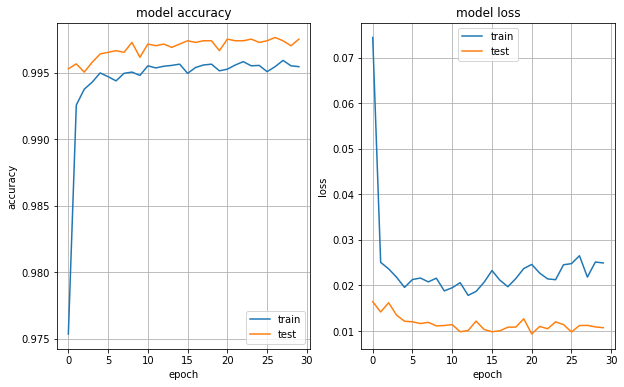

In [ ]:
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 6)
fig = plot_learning_curves_from_history_file("/content/training_logs/"+MODEL_NAME+".csv")

In [ ]:
from IPython.display import SVG
import numpy
import os
import cv2
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import image
import numpy as np

In [ ]:
CHECKPOINT_BASE_PATH = "/content/model-checkpoints/"
CHECKPOINT_FILENAME = "vgg_weights.21-0.01.hdf5"
DATASET_BASE_PATH = "/content"
DATASET_PATH = "/content/dataset1"

plt.rcParams['figure.figsize'] = [10, 5]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 4608)              14714688  
_________________________________________________________________
dense (Dense)                (None, 512)               2359808   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 17,338,178
Trainable params: 2,623,490
Non-trainable params: 14,714,688
____________________________________

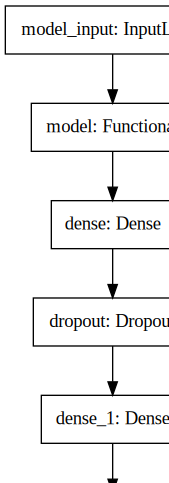

In [ ]:
# load json and create model
model = load_model(CHECKPOINT_BASE_PATH+CHECKPOINT_FILENAME)
plot_model(model, show_shapes=True)
model.summary()


# Prediction


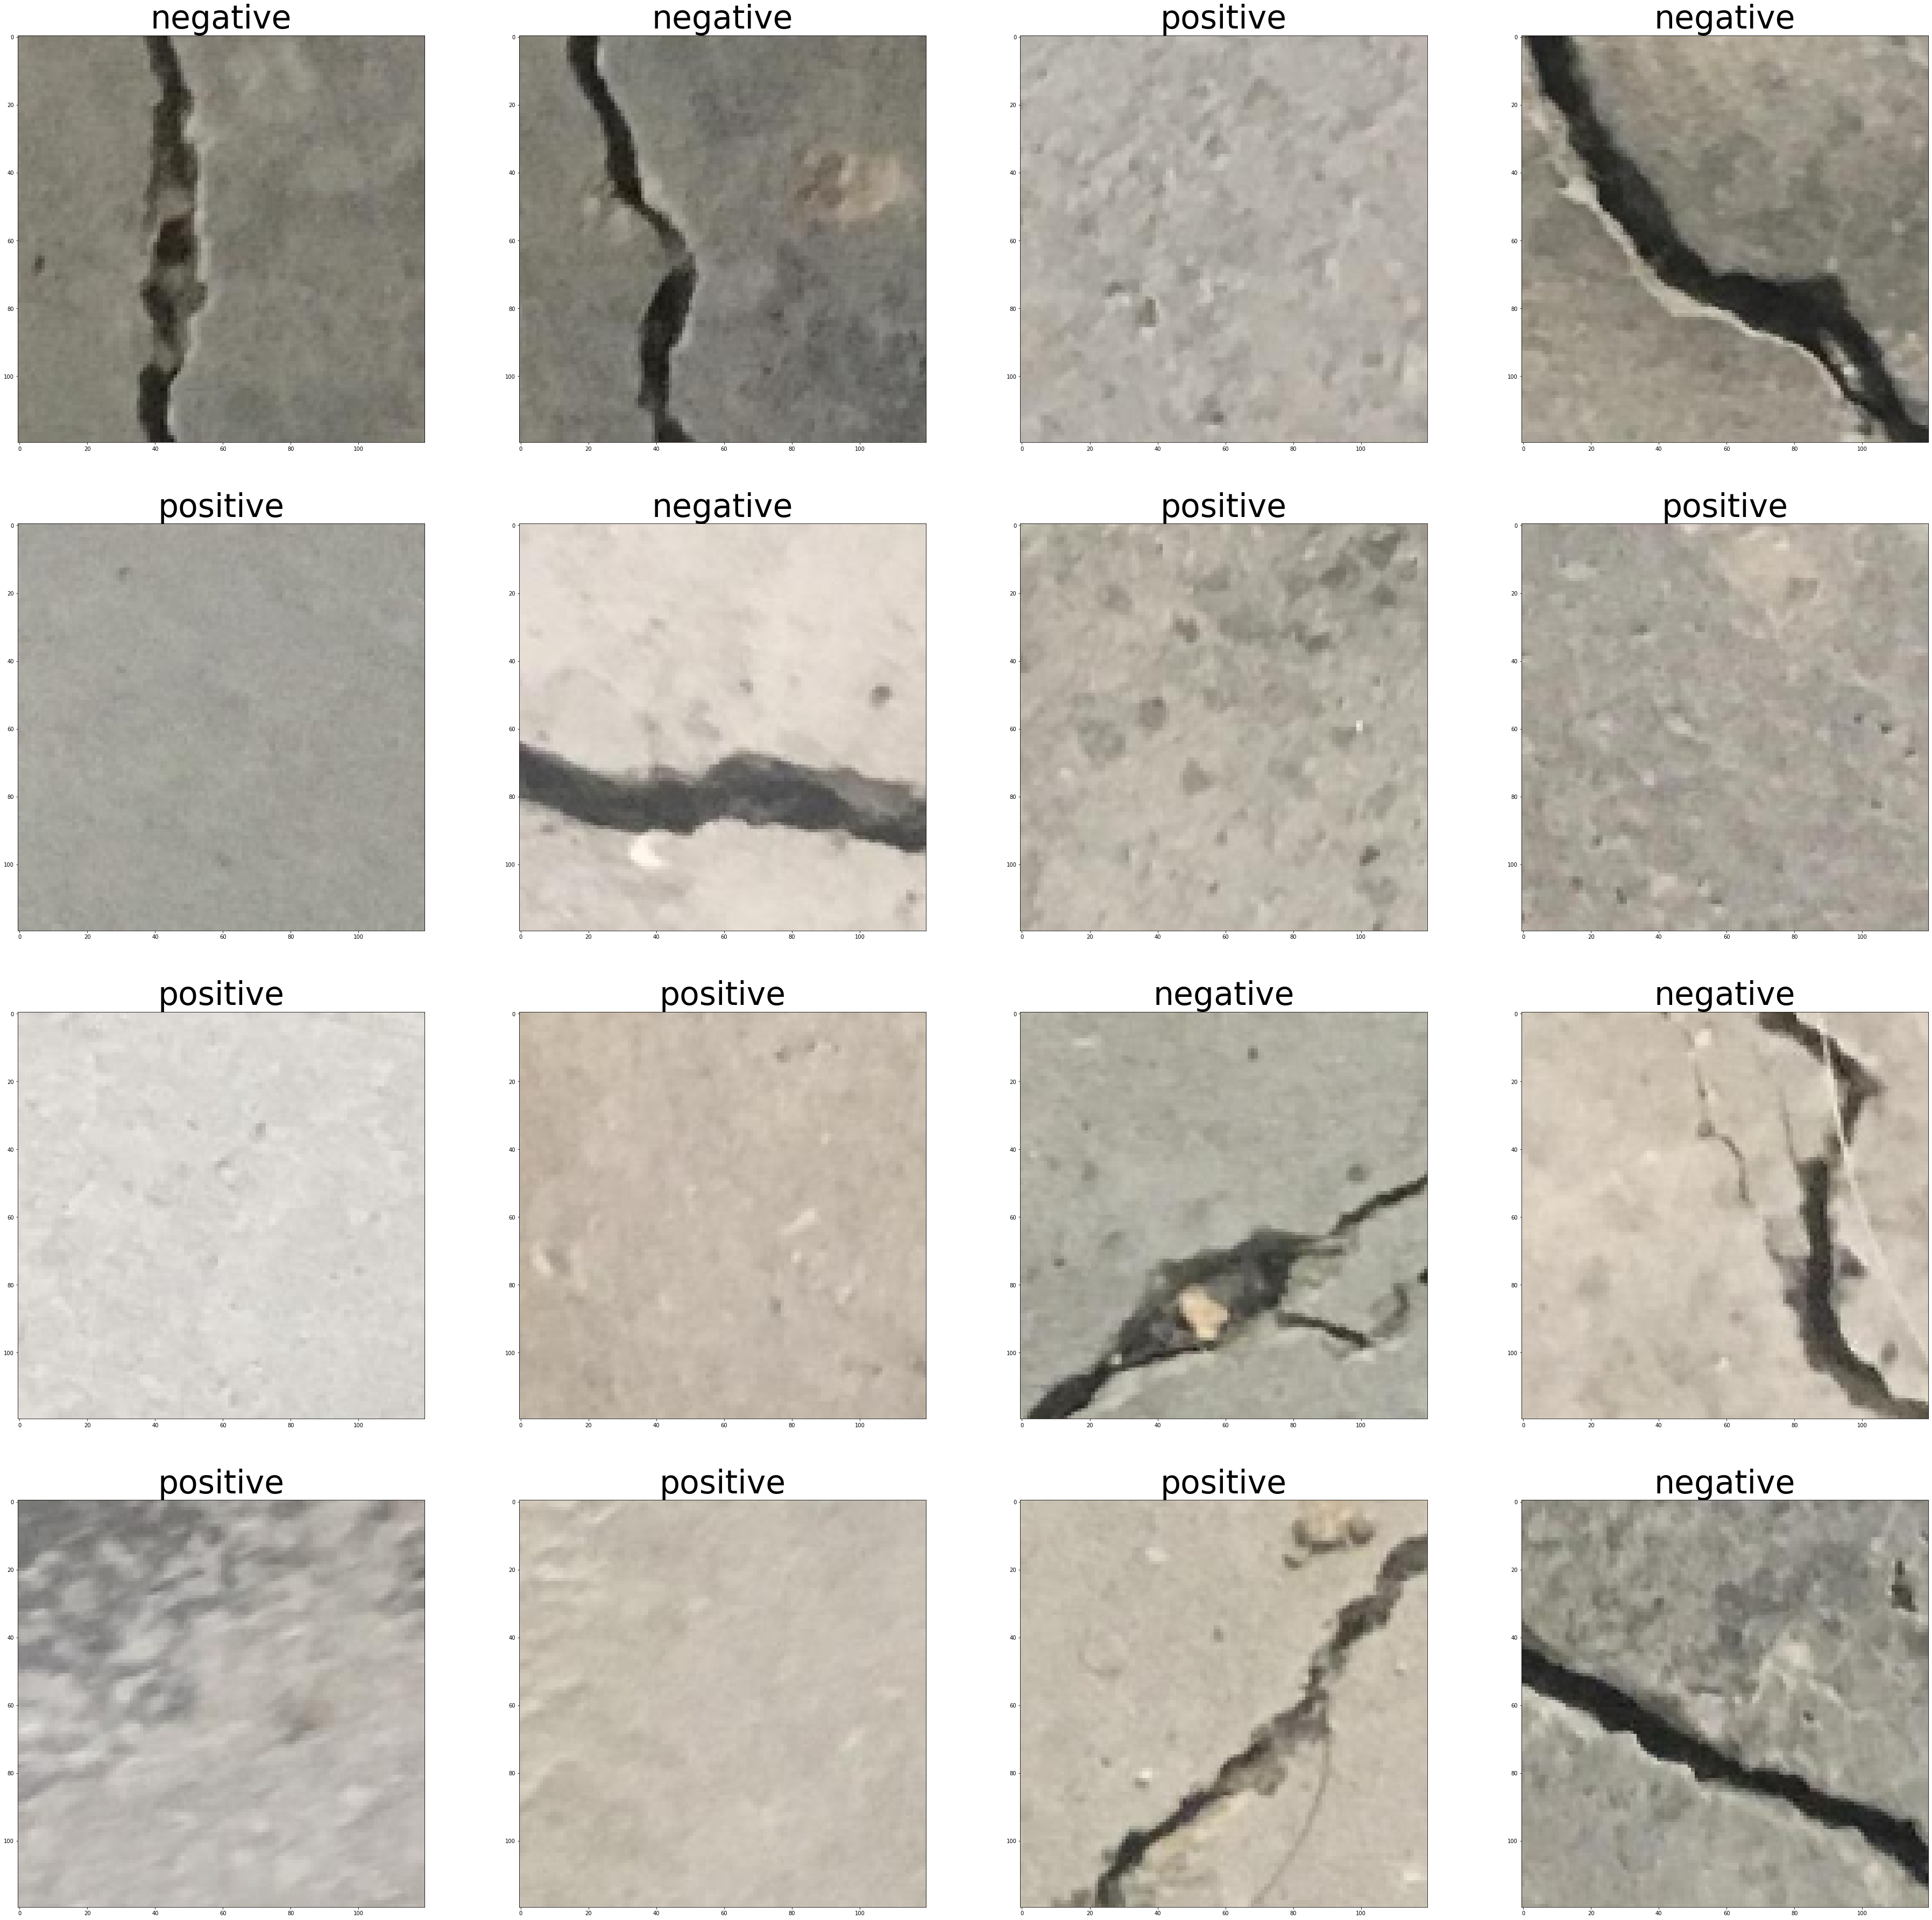

In [ ]:
class_names = [ "negative", "positive" ]

fig=plt.figure(figsize=(64, 64))
n_columns = 4
n_rows = 4
for i in range(1, n_columns*n_rows +1):
    img_filename = "/content/dataset1/demo/" + str(i) + '.jpg'
    img = cv2.imread(img_filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    img = cv2.resize(img, (120,120))
    fig.add_subplot(n_rows, n_columns, i)
    img_converted = img.reshape(1,120,120,3)
    predicted_class =  numpy.round(model.predict(img_converted)[0][0]).astype(int)
        
    plt.imshow(img)
    plt.title(class_names[int(predicted_class)], fontsize=60)

plt.show()

# ResNet50

In [3]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [4]:
from keras.applications.resnet50 import ResNet50

In [18]:
# Base resnet50
res = ResNet50(
    include_top=False, 
    weights='imagenet', 
    input_shape=(INPUT_IMG_DIM, INPUT_IMG_DIM, 3)
)

# Flatten output layer
output = res.layers[-1].output
output = tensorflow.keras.layers.Flatten()(output)

res_model = Model(res.input, output)
res_model.trainable = False

In [19]:
for layer in res_model.layers:
    layer.trainable = False

res_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 126, 126, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 60, 60, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 60, 60, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [20]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer 
from tensorflow.keras.models import Sequential 
from tensorflow.keras import optimizers 



adam = optimizers.Adam()

model = Sequential() 
model.add(res_model) 
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.3)) 
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.3)) 
model.add(Dense(2, activation='softmax')) 

model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

In [21]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [22]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [23]:
train_path="/content/dataset1/train"
test_path="/content/dataset1/val"

In [24]:

train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (120, 120),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 31906 images belonging to 2 classes.


In [25]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (120, 120),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 8094 images belonging to 2 classes.


In [26]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint



checkpoint = ModelCheckpoint(filepath='/content/gdrive/MyDrive/data1/resnet_model.h5', 
                               verbose=2, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model_history=model.fit_generator(
  train_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=5,
  validation_steps=32,
    callbacks=callbacks ,verbose=2)


duration = datetime.now() - start
print("Training completed in time: ", duration)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
5/5 - 41s - loss: 5.8909 - accuracy: 0.6500 - val_loss: 1.0634 - val_accuracy: 0.9121

Epoch 00001: val_loss improved from inf to 1.06336, saving model to /content/gdrive/MyDrive/data1/resnet_model.h5
Epoch 2/10
5/5 - 7s - loss: 3.0283 - accuracy: 0.8438 - val_loss: 0.8030 - val_accuracy: 0.9541

Epoch 00002: val_loss improved from 1.06336 to 0.80302, saving model to /content/gdrive/MyDrive/data1/resnet_model.h5
Epoch 3/10
5/5 - 7s - loss: 0.4473 - accuracy: 0.9563 - val_loss: 0.1928 - val_accuracy: 0.9873

Epoch 00003: val_loss improved from 0.80302 to 0.19284, saving model to /content/gdrive/MyDrive/data1/resnet_model.h5
Epoch 4/10
5/5 - 7s - loss: 0.1763 - accuracy: 0.9750 - val_loss: 0.2737 - val_accuracy: 0.9883

Epoch 00004: val_loss did not improve from 0.19284
Epoch 5/10
5/5 - 8s - loss: 0.2239 - accuracy: 0.9875 - val_loss: 0.2090 - val_accuracy: 0.9863

Epoch 00005: val_loss did not improve from 0.19284
Epoch 6/10
5/5 - 7s - loss: 1.2309 - accuracy: 0.9500 - val_lo

In [28]:
#we are getting val_loss: 0.0613 - val_accuracy: 0.9971

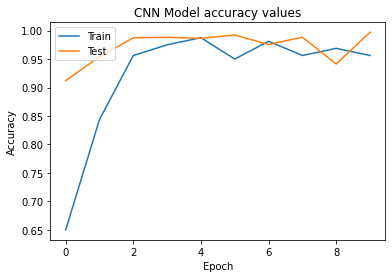

In [29]:
_# Plot training & validation loss values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Prediction

In [31]:

import numpy
import os
import cv2
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import image
import numpy as np

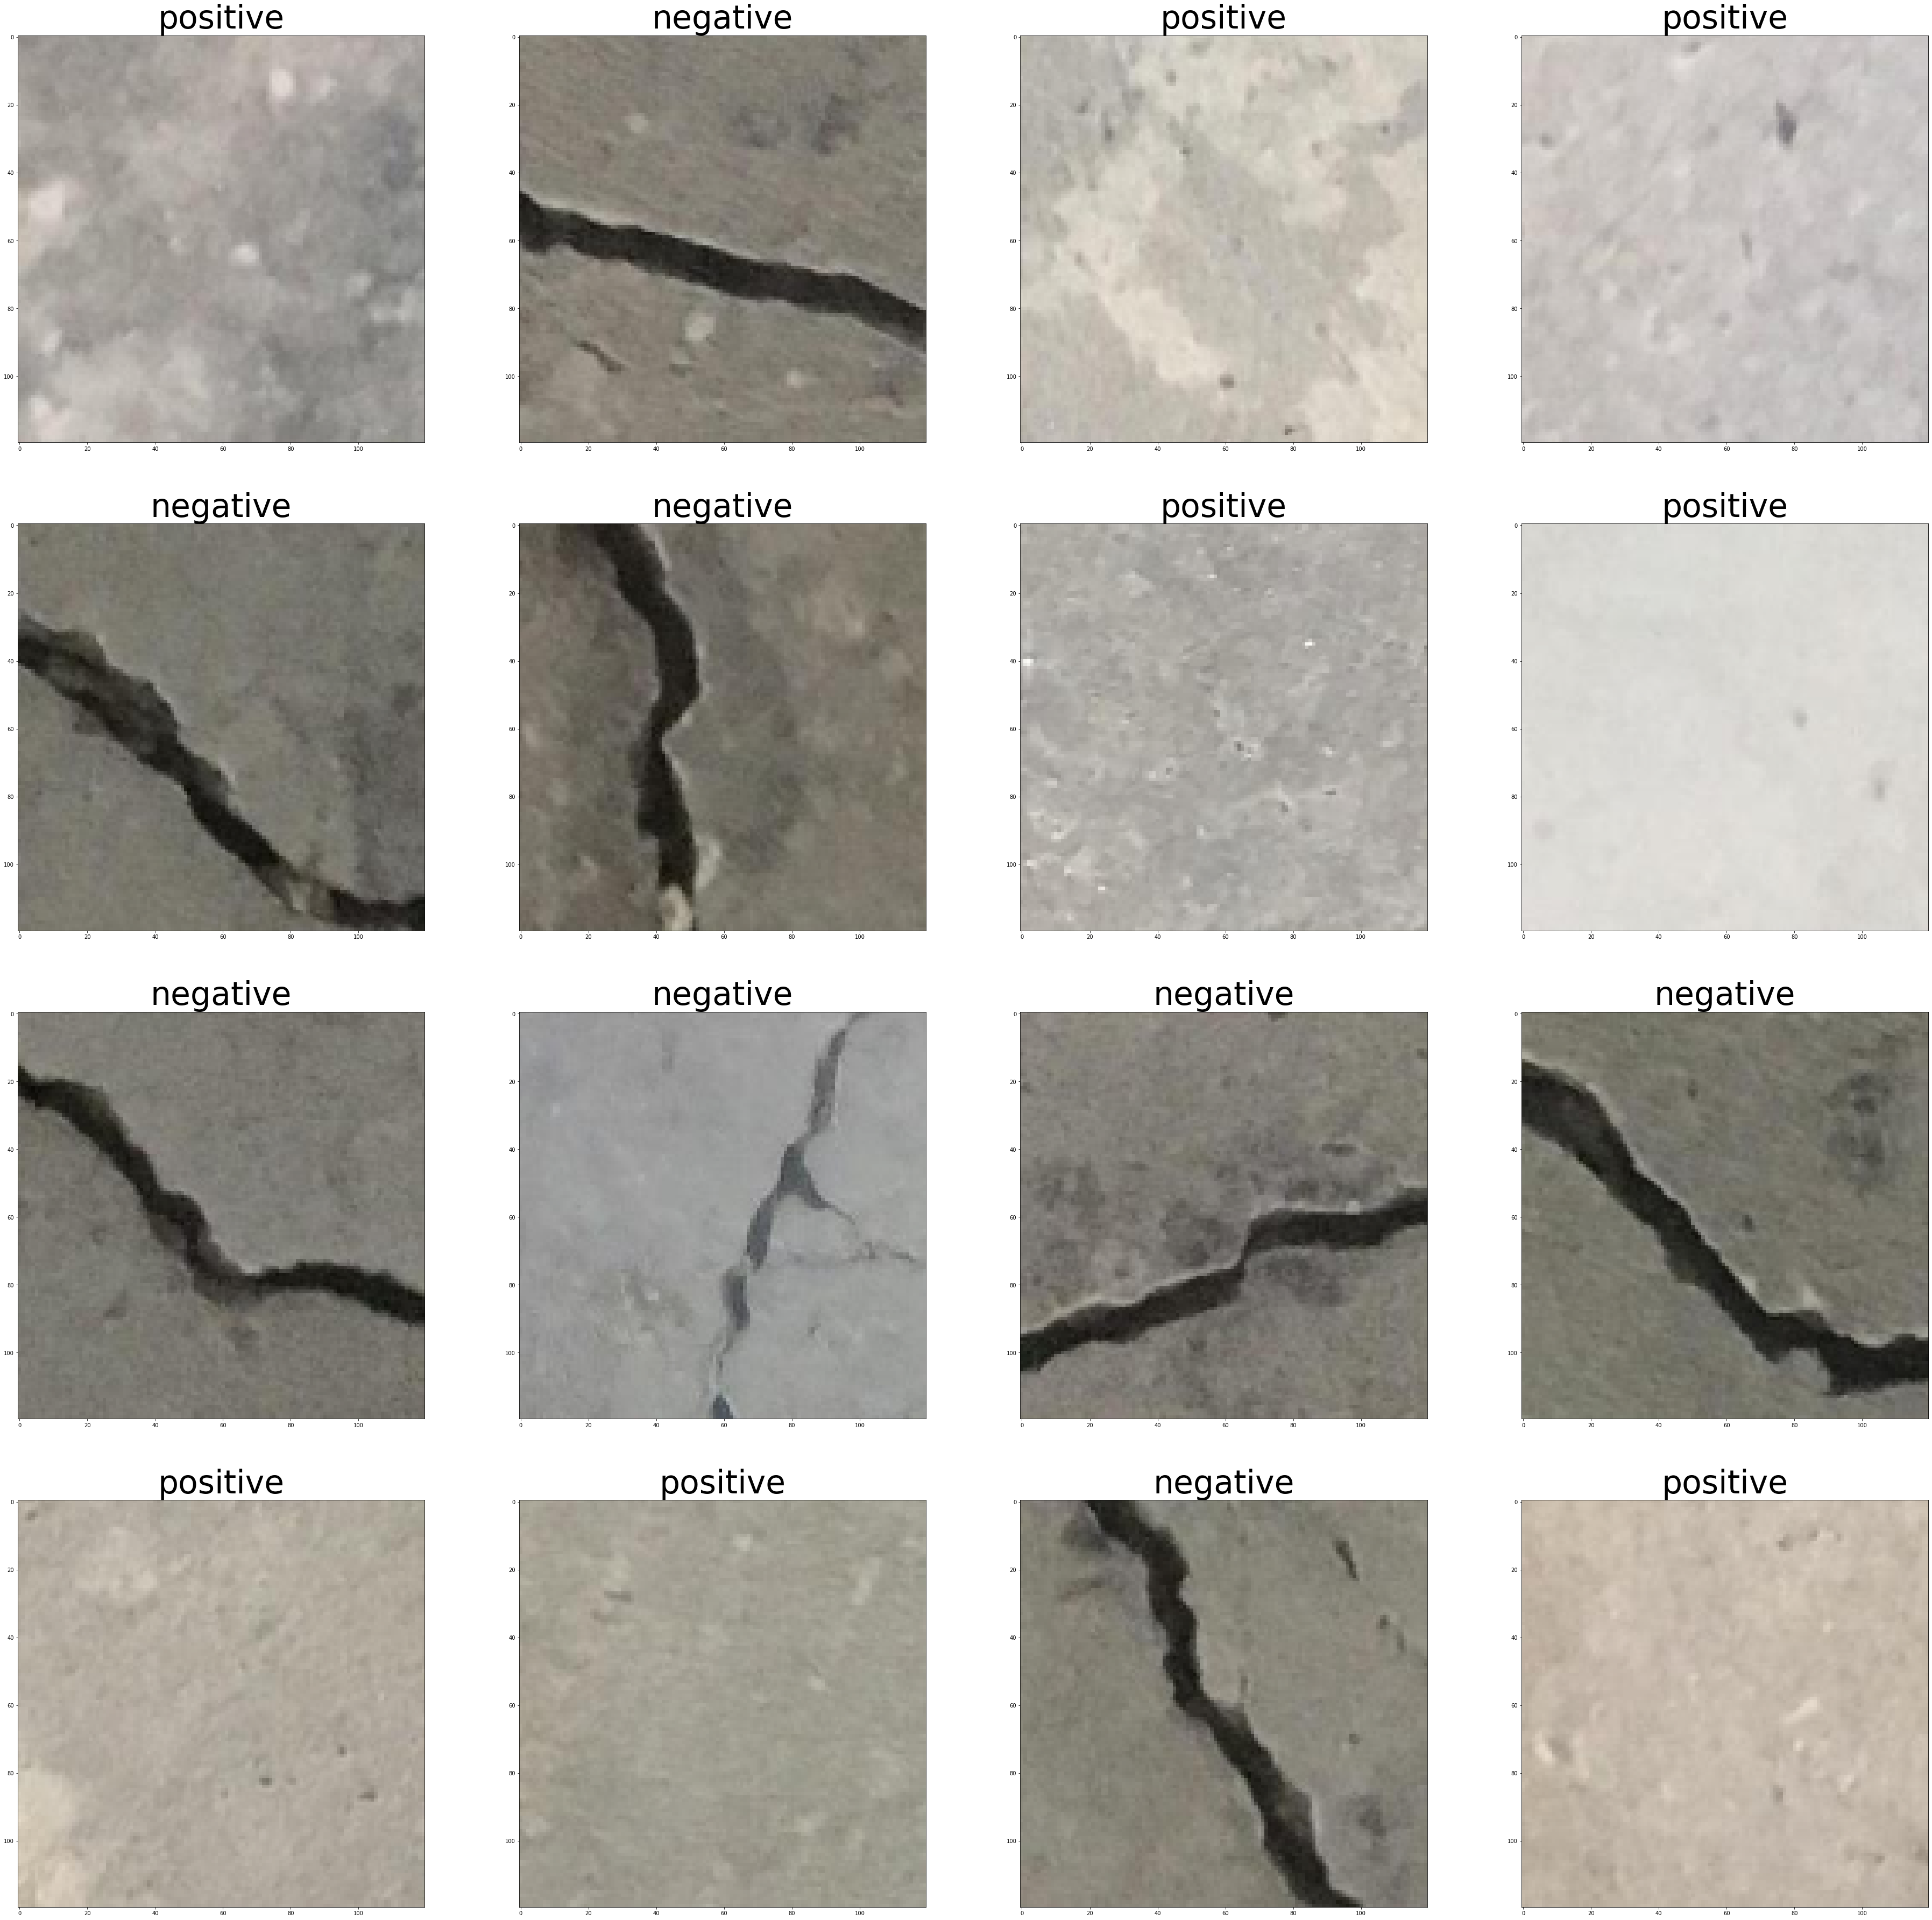

In [33]:
class_names = [ "negative", "positive" ]

fig=plt.figure(figsize=(64, 64))
n_columns = 4
n_rows = 4
for i in range(1, n_columns*n_rows +1):
    img_filename = "/content/gdrive/MyDrive/demo/" + str(i) + '.jpg'
    img = cv2.imread(img_filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    img = cv2.resize(img, (120,120))
    fig.add_subplot(n_rows, n_columns, i)
    img_converted = img.reshape(1,120,120,3)
    predicted_class =  numpy.round(model.predict(img_converted)[0][0]).astype(int)
        
    plt.imshow(img)
    plt.title(class_names[int(predicted_class)], fontsize=60)

plt.show()